In [ ]:
## TODO
- Testing on the server
- Add some more documentation
- Remove a few steps and instead provide hints to the workshop participant

# Fashion-MNIST: Simple Deep Neural Network for Image Classification

This tutorial will show you how to implement a simple convolutional neural network (ConvNet) in Keras for classifying images from the ''[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)'' dataset. The Fashion-MNIST dataset shares the same image size and structure of training and testing splits as the original [MNIST handwritten digit](http://yann.lecun.com/exdb/mnist/) dataset, which is often used as the "Hello World" example for object recognition with deep learning. 

In this tutorial you will learn:
- How to load MNIST datasets into Keras.
- How to implement a simple multi-layer perceptron neural network in Keras.
- How to implement and evaluate a simple Convolutional Neural Network (ConvNet).
- How to implement a close to state-of-the-art deep learning model in Keras. 

## Loading the Fashion-MNIST dataset in Keras

We will work with the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Each image is a 28 by 28 pixel square grayscale image (784 pixels in total), associated with a label from 10 classes. The dataset is split into 60,000 images used for training and 10,000 examples for testing. 

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's begin by loading the dataset and plots a few images.

In [93]:
# load the dataset
import utils.mnist_reader
(X_train, y_train) = mnist_reader.load_mnist('data/fashion', kind='train')
(X_test, y_test) = mnist_reader.load_mnist('data/fashion', kind='t10k')

# reshape arrays into 28x28 images
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

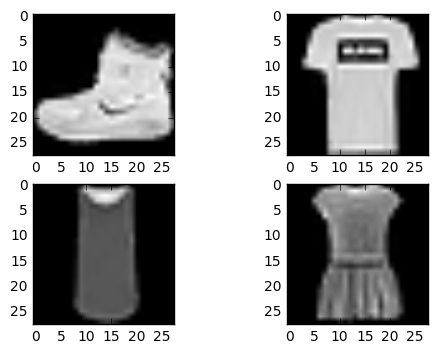

In [68]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

## Let's start with a simple neural network

Before we get to the more complex convolutional neural network, let's start with a simple multi-layer perceptron model as a baseline. 

First, let's import what we need. 

In [69]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

Initialize a random number generator, which is useful if you want to reproduce the results later.

In [70]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Load the dataset.

In [73]:
# load the dataset
import utils.mnist_reader
(X_train, y_train) = mnist_reader.load_mnist('data/fashion', kind='train')
(X_test, y_test) = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [74]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [75]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [76]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [77]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [78]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
3s - loss: 0.5033 - acc: 0.8235 - val_loss: 0.4250 - val_acc: 0.8484
Epoch 2/10
3s - loss: 0.3779 - acc: 0.8673 - val_loss: 0.3937 - val_acc: 0.8619
Epoch 3/10
3s - loss: 0.3359 - acc: 0.8784 - val_loss: 0.3858 - val_acc: 0.8643
Epoch 4/10
3s - loss: 0.3070 - acc: 0.8885 - val_loss: 0.3438 - val_acc: 0.8753
Epoch 5/10
3s - loss: 0.2885 - acc: 0.8949 - val_loss: 0.3607 - val_acc: 0.8644
Epoch 6/10
3s - loss: 0.2709 - acc: 0.9016 - val_loss: 0.3339 - val_acc: 0.8780
Epoch 7/10
3s - loss: 0.2620 - acc: 0.9025 - val_loss: 0.3178 - val_acc: 0.8837
Epoch 8/10
3s - loss: 0.2432 - acc: 0.9104 - val_loss: 0.3136 - val_acc: 0.8876
Epoch 9/10
3s - loss: 0.2340 - acc: 0.9141 - val_loss: 0.3148 - val_acc: 0.8875
Epoch 10/10
3s - loss: 0.2217 - acc: 0.9184 - val_loss: 0.3113 - val_acc: 0.8869
Baseline Error: 11.31%


The baseline error for this simple multi-layer perceptron neural net should be around 11.3%. 

## Simple convolutional neural network for MNIST

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

We start by importing the classes and functions needed.

In [79]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [80]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [82]:
# load the dataset
import utils.mnist_reader
(X_train, y_train) = mnist_reader.load_mnist('data/fashion', kind='train')
(X_test, y_test) = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [83]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
Next a fully connected layer with 128 neurons and rectifier activation function.
Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

In [84]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 200.

In [85]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
76s - loss: 0.5203 - acc: 0.8178 - val_loss: 0.3898 - val_acc: 0.8633
Epoch 2/10
76s - loss: 0.3505 - acc: 0.8767 - val_loss: 0.3414 - val_acc: 0.8778
Epoch 3/10
74s - loss: 0.3114 - acc: 0.8887 - val_loss: 0.3123 - val_acc: 0.8867
Epoch 4/10
78s - loss: 0.2821 - acc: 0.8983 - val_loss: 0.2893 - val_acc: 0.8963
Epoch 5/10
73s - loss: 0.2616 - acc: 0.9057 - val_loss: 0.2801 - val_acc: 0.9012
Epoch 6/10
75s - loss: 0.2475 - acc: 0.9101 - val_loss: 0.2762 - val_acc: 0.9002
Epoch 7/10
72s - loss: 0.2321 - acc: 0.9161 - val_loss: 0.2639 - val_acc: 0.9029
Epoch 8/10
75s - loss: 0.2196 - acc: 0.9191 - val_loss: 0.2562 - val_acc: 0.9069
Epoch 9/10
75s - loss: 0.2088 - acc: 0.9232 - val_loss: 0.2504 - val_acc: 0.9102
Epoch 10/10
75s - loss: 0.1991 - acc: 0.9266 - val_loss: 0.2481 - val_acc: 0.9137
CNN Error: 8.63%


The error for this simple convolutional neural net should be about 8.63% (after 10 epochs).

## Larger Convolutional Neural Network for MNIST

Finally, let's implement closer to the state of the art results.

In [87]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load the dataset
import utils.mnist_reader
(X_train, y_train) = mnist_reader.load_mnist('data/fashion', kind='train')
(X_test, y_test) = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

TODO
- Here I think we can just provide hints and leave it up to the workshop participant to implement the model. 

In [88]:
# define the larger model
def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Training: Like the previous two experiments, the model is fit over 10 epochs with a batch size of 200.

In [89]:
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 85s - loss: 0.7487 - acc: 0.7259 - val_loss: 0.4937 - val_acc: 0.8257

In [90]:
#Save partly trained model
model.save('partly_trained.h5')

#Load partly trained model
from keras.models import load_model
model = load_model('partly_trained.h5')

In [92]:
#Continue training
#model.fit(second_training, second_classes, batch_size=32, nb_epoch=5)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 83s - loss: 0.2668 - acc: 0.9016 - val_loss: 0.2880 - val_acc: 0.8957

Running the example prints accuracy on the training and validation datasets each epoch and a final classification error rate.

The model takes about 100 seconds to run per epoch. This slightly larger model achieves the respectable classification error rate of 0.89%.

There are many Keras image recognition tutorials online. If you're interested to learn more, here are some good ones:

- [TODO] Add links



This tutorial was heavily inspired by an excellent tutorial using MNIST for handwritten digit recognition, which you can find [here](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/).